## 1 - Carregando e preprocessando os dados

In [3]:
import gdown
import json # Importa a biblioteca json

google_drive_link = 'https://drive.google.com/uc?id=1QtLT6pXyOcMVGjMFjDaY8zc2w2cFWzGT'
output_filename = 'dados_confusão.txt' # O nome do arquivo de saída, mesmo que seja json, a extensão .txt não impede a leitura como json

gdown.download(google_drive_link, output_filename, quiet=False)

# Agora você pode ler o arquivo baixado como JSON
with open(output_filename, 'r') as f:
    dados_json = json.load(f) # Usa json.load() para carregar o conteúdo como um objeto JSON

print('\nDados carregados:')
print([(i['intent'], len(i['examples'])) for i in dados_json])

Downloading...
From: https://drive.google.com/uc?id=1QtLT6pXyOcMVGjMFjDaY8zc2w2cFWzGT
To: /home/sleig/dev/notebooks/ipynb/dados_confusão.txt
100%|██████████| 7.33k/7.33k [00:00<00:00, 214kB/s]


Dados carregados:
[('confusion', 69), ('certainty', 31), ('neutral_statement', 93)]


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Inicializar listas vazias para armazenar os dados
texts = []
intents = []

# Iterar sobre cada dicionário na lista dados_json
for entry in dados_json:
    intent = entry['intent'] # Obter o valor da chave 'intent'
    examples = entry['examples'] # Obter a lista de exemplos

    # Iterar sobre cada exemplo e adicionar à lista de textos e intentos correspondentes
    for example in examples:
        texts.append(example)
        intents.append(intent)

# Criar um DataFrame do pandas com as listas coletadas
df = pd.DataFrame({'text': texts, 'intent': intents})

# Exibir as primeiras linhas do DataFrame para verificar o resultado
display(df.sample(10))

,text,intent
69,Eu sei,certainty
65,A gente deve seguir reto ou ir para algum lugar?,confusion
146,Vou começar a fazer isso,neutral_statement
119,Eu não vou,neutral_statement
91,Isso está absolutamente correto,certainty
96,Tenho certeza absoluta sobre isso,certainty
101,Não,neutral_statement
111,Não é a mesma coisa,neutral_statement
134,"Isso é interessante, não é?",neutral_statement
166,O projeto em grupo está indo bem,neutral_statement


In [5]:
# Separar os dados em treino e teste usando amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['intent'],
                                                    test_size=0.20,
                                                    random_state=42)

print("\nDistribuição das classes no conjunto de treino:")
display(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
display(y_test.value_counts())


Distribuição das classes no conjunto de treino:


intent
neutral_statement    73
confusion            55
certainty            26
Name: count, dtype: int64


Distribuição das classes no conjunto de teste:


intent
neutral_statement    20
confusion            14
certainty             5
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# One-Hot Encoding nos labels
# Como a variável target já é uma série, precisamos remodela-la para o OneHotEncoder
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Inicializar o OneHotEncoder
# handle_unknown='ignore' é útil caso apareçam labels no teste que não estavam no treino
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajustar e transformar os labels de treino
onehot_encoder.fit(y_train_reshaped)
y_train_encoded = onehot_encoder.transform(y_train_reshaped)

# Transformar os labels de teste
y_test_encoded = onehot_encoder.transform(y_test_reshaped)

print("Formato dos labels originais (treino):", y_train.shape)
print("Formato dos labels após One-Hot Encoding (treino):", y_train_encoded.shape)
print("\nPrimeiros 5 labels de treino originais:\n", y_train.head())
print("\nPrimeiros 5 labels de treino após One-Hot Encoding:\n", y_train_encoded[:5])

print("\nFormato dos labels originais (teste):", y_test.shape)
print("Formato dos labels após One-Hot Encoding (teste):", y_test_encoded.shape)
print("\nPrimeiros 5 labels de teste originais:\n", y_test.head())
print("\nPrimeiros 5 labels de teste após One-Hot Encoding:\n", y_test_encoded[:5])

# Agora y_train_encoded e y_test_encoded contêm os rótulos em formato one-hot encoded.
# Você usaria essas variáveis se o seu modelo de classificação as exigisse.

Formato dos labels originais (treino): (154,)
Formato dos labels após One-Hot Encoding (treino): (154, 3)

Primeiros 5 labels de treino originais:
 82             certainty
109    neutral_statement
163    neutral_statement
35             confusion
136    neutral_statement
Name: intent, dtype: object

Primeiros 5 labels de treino após One-Hot Encoding:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]

Formato dos labels originais (teste): (39,)
Formato dos labels após One-Hot Encoding (teste): (39, 3)

Primeiros 5 labels de teste originais:
 45             confusion
137    neutral_statement
76             certainty
144    neutral_statement
113    neutral_statement
Name: intent, dtype: object

Primeiros 5 labels de teste após One-Hot Encoding:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


## 2 - Classificação

### Método A - TF-IDF e DecisionTreeClassifier

#### Ajustando o TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Inicializar o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(X_train)

X_train_tfidf = tfidf_vectorizer.transform(X_train)

#### Interpretando o TF-IDF por dentro

In [8]:
def palavras_importantes(X, tfidf_vectorizer):
  # Obter os nomes das features (palavras)
  feature_names = tfidf_vectorizer.get_feature_names_out()

  # Obter métricas de relevância
  average_tfidf_scores = X_train_tfidf.mean(axis=0).A1

  # Criar um DataFrame para visualizar as palavras e suas pontuações médias
  tfidf_scores_df = pd.DataFrame({'word': feature_names,
                                  'average_tfidf': average_tfidf_scores,
                                  'idf': tfidf_vectorizer.idf_})
  return tfidf_scores_df

palavras_importantes(X_train_tfidf, tfidf_vectorizer).sort_values(by='average_tfidf', ascending=False).head(10)

,word,average_tfidf,idf
152,isso,0.077684,2.214784
189,não,0.060776,2.711221
238,que,0.053132,2.785329
121,está,0.042093,3.098986
120,estou,0.028285,3.478476
241,quê,0.026879,3.846201
30,aqui,0.026743,3.846201
122,eu,0.025769,3.740840
292,você,0.025242,3.740840
55,como,0.024026,3.740840


#### Treinando um classificador usando TF-IDF e DecisionTreeClassifier

In [9]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report

# Aplicar o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer() # Parametrizar se necessário
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


### Classificador

# Inicializar o classificador
model = DecisionTreeClassifier(random_state=42)

# Treinar o classificador
model.fit(X_train_tfidf, y_train_encoded)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### Investigando o DecisionTreeClassifier por dentro

In [10]:
# Criar a visualização da árvore de decisão
print(export_text(model,
                  feature_names=tfidf_vectorizer.get_feature_names_out()))

|--- tenho <= 0.19
|   |--- quê <= 0.21
|   |   |--- gente <= 0.16
|   |   |   |--- como <= 0.42
|   |   |   |   |--- estou <= 0.32
|   |   |   |   |   |--- eu <= 0.35
|   |   |   |   |   |   |--- acontecendo <= 0.21
|   |   |   |   |   |   |   |--- está <= 0.34
|   |   |   |   |   |   |   |   |--- dúvida <= 0.22
|   |   |   |   |   |   |   |   |   |--- jeito <= 0.24
|   |   |   |   |   |   |   |   |   |   |--- minha <= 0.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |   |   |   |   |   |--- minha >  0.20
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- jeito >  0.24
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- dúvida >  0.22
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- está >  0.34
|   |   |   |   |   |   |   |   |--- isso <= 0.12
|   |   |   |   |   |   |   |   |   |--- certeza <= 0.25
|   |   |   

In [11]:
palavra = "tenho"

ix = np.argwhere(tfidf_vectorizer.get_feature_names_out()==palavra)[0][0]
ix

np.int64(269)

In [12]:
tfidf_vectorizer.transform(['eu tenho a força']).toarray()[0,ix]

np.float64(0.7385186358375196)

#### Avaliando a performance do classificador nos dados de teste

In [13]:
# Transformar os dados de teste usando o mesmo TF-IDF Vectorizer treinado nos dados de treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test_tfidf)

# Avaliar o modelo
print(classification_report(y_test_encoded, predictions))

              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.47      0.50      0.48        14
           2       0.70      0.70      0.70        20

   micro avg       0.58      0.56      0.57        39
   macro avg       0.50      0.47      0.48        39
weighted avg       0.57      0.56      0.56        39
 samples avg       0.56      0.56      0.56        39



/home/sleig/.cache/pypoetry/virtualenvs/notebooks-WtJaZIpw-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [14]:
# Testando um algoritmo mais avançado:
from sklearn.ensemble import RandomForestClassifier

# Aplicar o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer() # Parametrizar se necessário
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Inicializar o classificador
model_rf = RandomForestClassifier()

# Treinar o classificador
model_rf.fit(X_train_tfidf, y_train_encoded)

# Transformar os dados de teste usando o mesmo TF-IDF Vectorizer treinado nos dados de treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Fazer previsões no conjunto de teste
predictions_rf = model_rf.predict(X_test_tfidf)

# Avaliar o modelo
print(classification_report(y_test_encoded, predictions_rf))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.86      0.43      0.57        14
           2       0.70      0.70      0.70        20

   micro avg       0.72      0.54      0.62        39
   macro avg       0.69      0.44      0.52        39
weighted avg       0.73      0.54      0.60        39
 samples avg       0.54      0.54      0.54        39



/home/sleig/.cache/pypoetry/virtualenvs/notebooks-WtJaZIpw-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


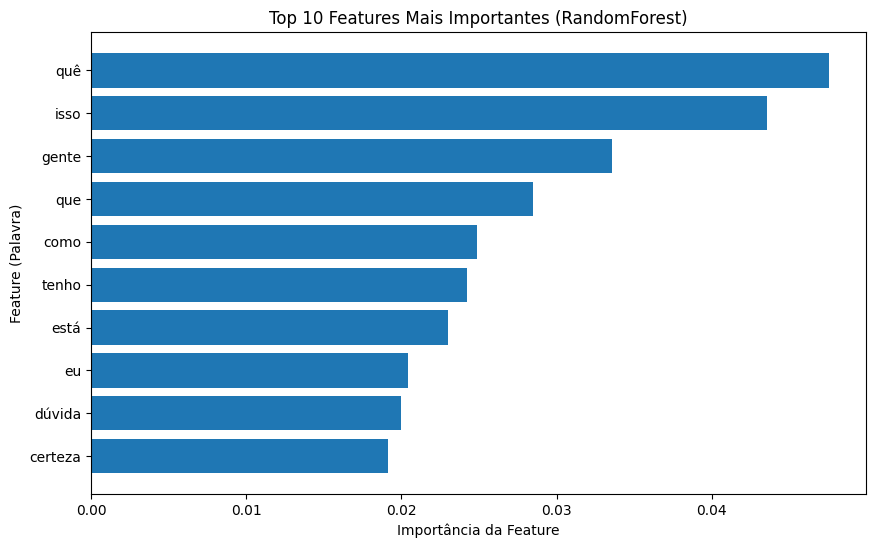

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Obter as importâncias das features do modelo RandomForest
# Como o modelo está dentro de um pipeline, acessamos o estimador RandomForest
feature_importances = model_rf.feature_importances_

# Obter os nomes das features do TF-IDF Vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Ordenar as features por importância e pegar as top 10
top_10_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

# Plotar as top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'])
plt.xlabel('Importância da Feature')
plt.ylabel('Feature (Palavra)')
plt.title('Top 10 Features Mais Importantes (RandomForest)')
plt.gca().invert_yaxis() # Inverter o eixo y para a feature mais importante ficar no topo
plt.show()

### Método B - Classificador com Embeddings e DecisionTreeClassifier

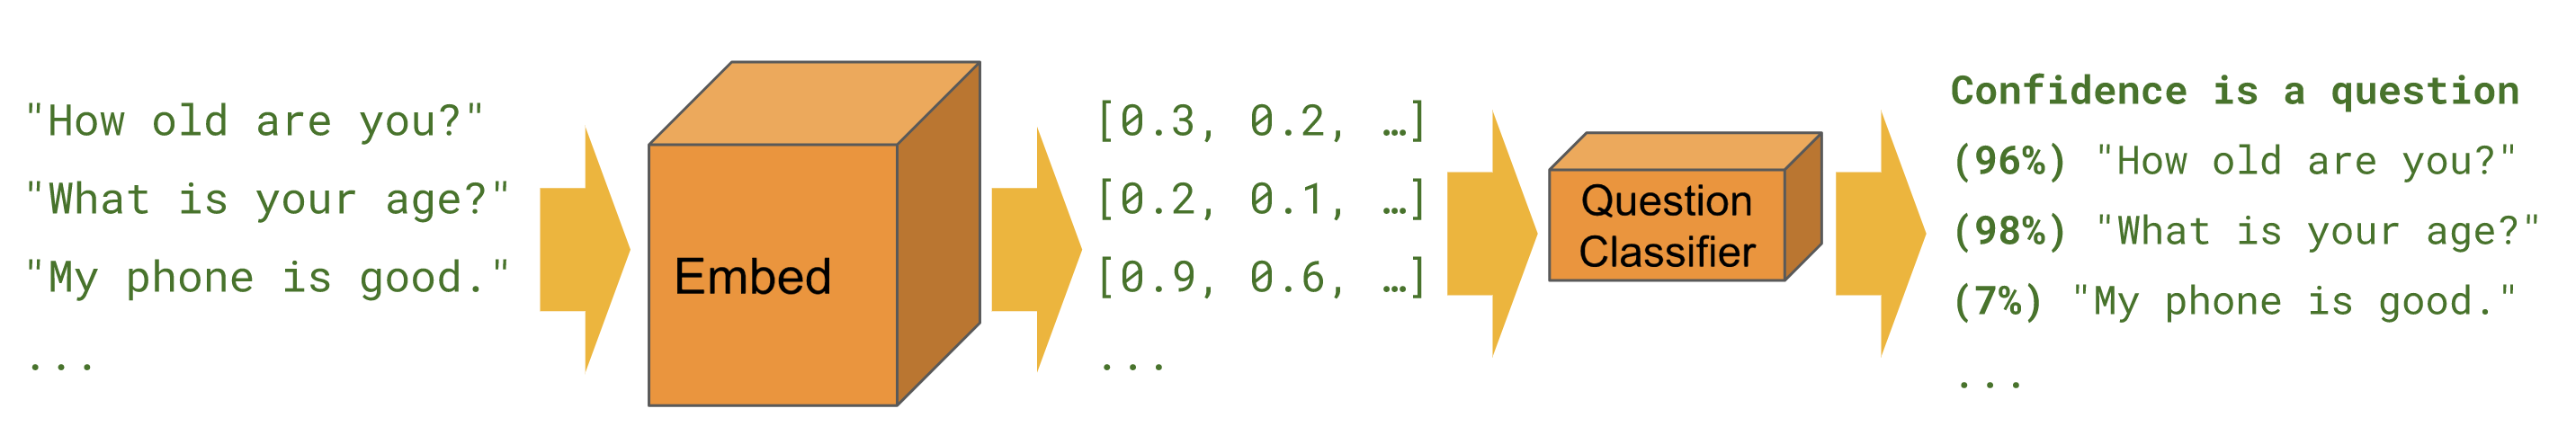

In [16]:
import tensorflow_hub as hub

embeddings = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

embeddings

ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
X_train_tfidf.shape

(154, 294)

In [ ]:
embeddings(['Hello world']).shape

TensorShape([1, 512])

#### Embeddings são úteis para medir "similaridade semântica"

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Frases para comparação
frase1 = "Meu gato preto está dormindo na cadeira."
frase2 = "Nosso felino escuro ta descansando no assento."
frase3 = "My black cat is sleeping in the chair."

print(f"Frase 1: {frase1}")
print(f"Frase 2: {frase2}")
print(f"Frase 3: {frase3}")

# --- Similaridade com TF-IDF ---
print("\n--- Similaridade com TF-IDF ---")

# Transformar as frases usando o TF-IDF Vectorizer treinado anteriormente
# É importante que o TF-IDF Vectorizer tenha sido ajustado em um corpus maior
# para capturar melhor as relações das palavras. O vectorizer 'tfidf_vectorizer'
# foi ajustado nos dados de treino do dataset original.
tfidf_frase1 = tfidf_vectorizer.transform([frase1])
tfidf_frase2 = tfidf_vectorizer.transform([frase2])
tfidf_frase3 = tfidf_vectorizer.transform([frase3])

# Calcular a similaridade de cosseno entre os vetores TF-IDF
sim_tfidf_1_2 = cosine_similarity(tfidf_frase1, tfidf_frase2)[0][0]
sim_tfidf_1_3 = cosine_similarity(tfidf_frase1, tfidf_frase3)[0][0]
sim_tfidf_2_3 = cosine_similarity(tfidf_frase2, tfidf_frase3)[0][0]


print(f"Similaridade TF-IDF (Frase 1 vs Frase 2): {sim_tfidf_1_2:.4f}")
print(f"Similaridade TF-IDF (Frase 1 vs Frase 3): {sim_tfidf_1_3:.4f}")
print(f"Similaridade TF-IDF (Frase 2 vs Frase 3): {sim_tfidf_2_3:.4f}")

# --- Similaridade com Embeddings (Universal Sentence Encoder) ---
print("\n--- Similaridade com Embeddings (Universal Sentence Encoder) ---")

# Transformar as frases usando o modelo de embeddings
embeddings_frase1 = embeddings([frase1])
embeddings_frase2 = embeddings([frase2])
embeddings_frase3 = embeddings([frase3])


# Calcular a similaridade de cosseno entre os vetores de embeddings
sim_embeddings_1_2 = cosine_similarity(embeddings_frase1, embeddings_frase2)[0][0]
sim_embeddings_1_3 = cosine_similarity(embeddings_frase1, embeddings_frase3)[0][0]
sim_embeddings_2_3 = cosine_similarity(embeddings_frase2, embeddings_frase3)[0][0]

print(f"Similaridade Embeddings (Frase 1 vs Frase 2): {sim_embeddings_1_2:.4f}")
print(f"Similaridade Embeddings (Frase 1 vs Frase 3): {sim_embeddings_1_3:.4f}")
print(f"Similaridade Embeddings (Frase 2 vs Frase 3): {sim_embeddings_2_3:.4f}")

print("\n--- Análise ---")

Frase 1: Meu gato preto está dormindo na cadeira.
Frase 2: Nosso felino escuro ta descansando no assento.
Frase 3: My black cat is sleeping in the chair.

--- Similaridade com TF-IDF ---
Similaridade TF-IDF (Frase 1 vs Frase 2): 0.0000
Similaridade TF-IDF (Frase 1 vs Frase 3): 0.0000
Similaridade TF-IDF (Frase 2 vs Frase 3): 0.0000

--- Similaridade com Embeddings (Universal Sentence Encoder) ---
Similaridade Embeddings (Frase 1 vs Frase 2): 0.6203
Similaridade Embeddings (Frase 1 vs Frase 3): 0.1987
Similaridade Embeddings (Frase 2 vs Frase 3): 0.0520

--- Análise ---


#### Utilizando embeddings para treinar nosso classificador

In [ ]:
# Aplicar os embeddings nos dados de treino e teste
X_train_embeddings = embeddings(X_train)
X_test_embeddings = embeddings(X_test)

print("Formato dos embeddings de treino:", X_train_embeddings.shape)
print("Formato dos embeddings de teste:", X_test_embeddings.shape)

Formato dos embeddings de treino: (154, 512)
Formato dos embeddings de teste: (39, 512)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Inicializar o modelo Decision Tree
model_embedding = DecisionTreeClassifier()

# Treinar o modelo com os embeddings de treino e labels originais
model_embedding.fit(X_train_embeddings, y_train_encoded)

# Fazer previsões no conjunto de teste usando os embeddings de teste
predictions_embedding = model_embedding.predict(X_test_embeddings)

# Avaliar o modelo
print("Relatório de Classificação (Decision Tree com Embeddings):")
print(classification_report(y_test_encoded, predictions_embedding))

Relatório de Classificação (Decision Tree com Embeddings):
              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.33      0.21      0.26        14
           2       0.59      0.65      0.62        20

   micro avg       0.50      0.49      0.49        39
   macro avg       0.45      0.49      0.46        39
weighted avg       0.48      0.49      0.48        39
 samples avg       0.49      0.49      0.49        39



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3 - Laboratório 3 - Introdução a classificação de texto

Nesta tarefa, vocês aplicarão os conceitos de classificação de texto que exploramos neste notebook.

O objetivo do laboratório será construir e avaliar um modelo de classificação capaz de prever a intenção de uma frase (confusão, certeza, ou afirmação neutra) usando técnicas como TF-IDF e Embeddings.


### **Instruções**

Sigam os passos abaixo, utilizando o código deste notebook como referência e adaptando-o quando necessário:

#### Carregar os Dados:

- Utilize o código inicial do notebook para carregar os dados do arquivo dados_confusão.txt.
- Transforme os dados em um DataFrame pandas com as colunas 'text' e 'intent'.
- Análise e Preparação dos Dados:

- Verifique a distribuição das classes (intent) no dataset.
- Divida o dataset em conjuntos de treino e teste (por exemplo, 80% treino, 20% teste).

#### Classificação com TF-IDF e Decision Tree:

- Aplique o TfidfVectorizer nos dados de treino (X_train).
- Analise as palavras com maior pontuação TF-IDF, como fizemos no notebook.
- Treine um modelo DecisionTreeClassifier utilizando os dados de treino transformados pelo TF-IDF (X_train_tfidf) e os rótulos de treino (y_train).
- Transforme os dados de teste (X_test) usando o mesmo TfidfVectorizer treinado nos dados de treino.
- Faça previsões no conjunto de teste.
- Avalie a performance do modelo no conjunto de teste usando o classification_report. Analisem as métricas (Precision, Recall, F1-score) e o que elas indicam sobre o desempenho do modelo em cada classe.

#### Classificação com Embeddings:

- Aplique nos dados de treino (X_train) e teste (X_test) para obter os vetores de embeddings.
- Treine um modelo DecisionTreeClassifier (ou outro classificador de sua escolha, como RandomForestClassifier) utilizando os embeddings de treino e os rótulos de treino.
- Faça previsões no conjunto de teste usando os embeddings de teste.

### Entrega

Comparem o desempenho dos modelos respondendo às seguintes perguntas:

- Compare os relatórios de classificação dos modelos treinados (TF-IDF + Decision Tree e Embeddings + Classificador).
- Qual abordagem (TF-IDF vs. Embeddings) pareceu funcionar melhor para este dataset e por quê? Considerem o tamanho e a natureza dos dados.
- Quais classes o(s) modelo(s) tiveram mais dificuldade em classificar corretamente? O que isso pode indicar?

Submetam o código completo da tarefa (em notebook) e incluam células de texto no final do notebook para apresentar suas análises e respostas às perguntas.


## Resposta

1. Compare os relatórios de classificação dos modelos treinados (TF-IDF + Decision Tree e Embeddings + Classificador).
- Resposta: ...


2. Qual abordagem (TF-IDF vs. Embeddings) pareceu funcionar melhor para este dataset e por quê? Considerem o tamanho e a natureza dos dados.
- Resposta: ...

3. Quais classes o(s) modelo(s) tiveram mais dificuldade em classificar corretamente? O que isso pode indicar?
- Resposta: ...